In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import time

from deap import algorithms
from deap import base
from deap import benchmarks
from deap import cma
from deap import creator
from deap import tools

import sys
sys.path.append("../../../modules/")
import sim2d2link as sim

In [2]:
INIT_THETA1 = 0.0
INIT_THETA2 = 0.0
POS_GOAL1 = np.array([[1.0, 1.0]])
POS_GOAL2 = np.array([[0.0, 2.0]])
POS_GOAL3 = np.array([[-1.0, 1.0]])

In [3]:
def fk(init_theta1, init_theta2, a1, a2, armL=1.0):
    next_theta1 = init_theta1 + a1
    next_theta2 = init_theta2 + a2
    x = armL*np.cos(next_theta1) + armL*np.cos(next_theta1+next_theta2)
    y = armL*np.sin(next_theta1)+ armL*np.sin(next_theta1+next_theta2)
    pos_pred = np.array([x, y])
    return next_theta1, next_theta2, pos_pred

def evaluate(individual):
    a01, a02, a11, a12, a21, a22 = individual
    theta11, theta12, pos_pred = fk(INIT_THETA1, INIT_THETA2, a01, a02)
    cost1 = np.linalg.norm(pos_pred-POS_GOAL1)
    theta21, theta22, pos_pred = fk(theta11, theta12, a11, a12)
    cost2 = np.linalg.norm(pos_pred-POS_GOAL2)
    _, _, pos_pred = fk(theta21, theta22, a21, a22)
    cost3 = np.linalg.norm(pos_pred-POS_GOAL3)
    
    return cost1, cost2, cost3,

# def evaluate(individual):
#     a01, a02, a11, a12, a21, a22 = individual
    
#     return a01+a02, a11+a12, a21+a22,

In [4]:
def solve(IND_DIM, NSTATE, NPOP, NGEN, MU, LAMBDA):
    t1 = time.time() 
    np.random.seed(64)

    creator.create("FitnessMin", base.Fitness, weights=tuple([-1 for i in range(NSTATE)]))
    creator.create("Individual", np.ndarray, fitness=creator.FitnessMin)
    toolbox = base.Toolbox()
    toolbox.register("evaluate", evaluate)
    
    population = [creator.Individual(x) for x in (np.random.uniform(0, 1, (NPOP, IND_DIM)))]
    for ind in population:
        ind.fitness.values = toolbox.evaluate(ind)
    
    strategy = cma.StrategyMultiObjective(population, sigma=1.0, mu=MU, lambda_=LAMBDA)
    
    toolbox.register("generate", strategy.generate, creator.Individual)
    toolbox.register("update", strategy.update)
    
    halloffame = tools.HallOfFame(1, similar=np.array_equal)

    mean_fitness = []
    halloffame_array = []
    C_array = []
    centroid_array = []
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)
    logbook = tools.Logbook()
    logbook.header = ["gen", "nevals"] + (stats.fields if stats else [])
    fitness_history = []

    for gen in range(NGEN):
        stack_fitness = []
        population = toolbox.generate()
        fitnesses = toolbox.map(toolbox.evaluate, population)
        for ind, fit in zip(population, fitnesses):
            ind.fitness.values = fit
            stack_fitness.append(fit)         
        toolbox.update(population)
        halloffame.update(population)

        record = stats.compile(population) if stats is not None else {}
        logbook.record(gen=gen, nevals=len(population), **record)
#         print(logbook.stream)

    t2 = time.time() 
    elapsed_time = t2-t1
    print(f"solving time: {elapsed_time:.3f}s")
    
    id_best = 0
    eval_best = 1e10
    for i in range(len(population)):
        eval = sum(toolbox.evaluate(population[i]))
        if eval < eval_best:
            id_best = i
            eval_best = eval
            
    
    
    return population[id_best]

In [5]:
INIT_THETA1 = 0.0
INIT_THETA2 = 0.0
POS_GOAL1 = np.array([[1.0, 1.0]])
POS_GOAL2 = np.array([[0.0, 2.0]])
POS_GOAL3 = np.array([[-1.0, 1.0]])

command = solve(IND_DIM=6, NSTATE=3, NPOP=10, NGEN=600, MU=10, LAMBDA=10)

solving time: 1.133s


MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


drawing time: 4.635s


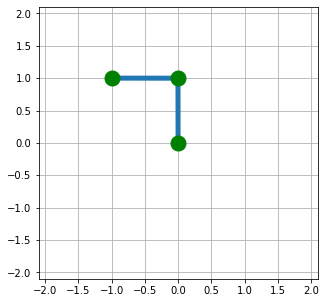

In [8]:
sim.draw(command, save_path="../logs/2link3state_cmaes.gif")